In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
log_filepath  = './inception_resnet_v2'
from skimage.transform import resize
import tensorflow as tf
import skimage
import skimage.io
import skimage.transform

Using TensorFlow backend.


# Load InceptionResNetV2

In [2]:
from keras.applications import InceptionResNetV2

In [3]:
irnv = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

 # Create the model
model = models.Sequential()

model.add(irnv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 55,920,874
Trainable params: 55,860,330
Non-trainable params: 60,544
_________________________________________________________________


# Load data

In [15]:
import random
import cv2
from keras.optimizers import SGD
from keras.optimizers import Nadam

In [20]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


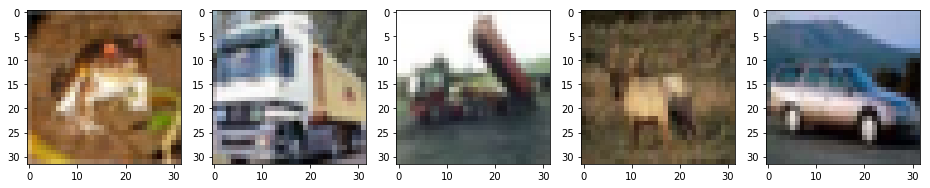

In [21]:
import matplotlib.pyplot as plt

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = x_train[i]
    axarr[i].imshow(img)

In [ ]:
# limit the amount of the data
# train data
ind_train = random.sample(list(range(x_train.shape[0])), 5000)
x_train = x_train[ind_train]
y_train = y_train[ind_train]

# test data
ind_test = random.sample(list(range(x_test.shape[0])), 5000)
x_test = x_test[ind_test]
y_test = y_test[ind_test]

In [23]:
def resize_data(data):
    data_upscaled = np.zeros((data.shape[0], 75, 75, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

In [24]:
# resize train and  test data
x_train_resized = resize_data(x_train)
x_test_resized = resize_data(x_test)

# make explained variable hot-encoded
y_train_hot_encoded = to_categorical(y_train)
y_test_hot_encoded = to_categorical(y_test)

In [25]:
x_train_resized = x_train_resized.astype('float32')
x_test_resized = x_test_resized.astype('float32')

# Normalization of pixel values (to [0-1] range)

x_train_resized /= 255
x_test_resized /= 255

In [11]:
x_train_resized.shape

(2000, 75, 75, 3)

In [26]:
model.compile(optimizer=Nadam(lr=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=None,
    schedule_decay=0.004), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_resized, y_train_hot_encoded, batch_size=256, epochs=50, shuffle=True,  validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
4352/9000 [=============>................] - ETA: 15:44 - loss: nan - acc: 0.1025

KeyboardInterrupt: 

In [27]:
import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()